In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt


In [2]:
# Load trained model
model = XGBRegressor()
model.load_model("xgboost_demand_model.json")

# Load residuals
residuals = pd.read_csv("demand_residuals_xgboost_morefeatures.csv")["Residual"].values

# Load last known feature row
last_features = pd.read_csv("last_known_features_xgboost_morefeatures.csv")

# Feature column order
feature_cols = pd.read_csv("feature_columns_xgboost_morefeatures.csv")["feature_name"].tolist()
last_features = last_features[feature_cols]


In [17]:
N_SIMULATIONS = 500
HORIZON_DAYS = 120

INITIAL_INVENTORY = 600
REORDER_POINT = 379
ORDER_QUANTITY = 300
LEAD_TIME_DAYS = 14


In [18]:
def run_single_simulation():
    inventory = INITIAL_INVENTORY
    pending_orders = []
    inventory_history = []
    stockout = False

    features = last_features.copy()

    for day in range(HORIZON_DAYS):

        # Predict mean demand
        mean_demand = model.predict(features)[0]

        # Add uncertainty
        demand = max(0, mean_demand + np.random.choice(residuals))

        # Receive orders
        pending_orders = [(d-1, q) for d, q in pending_orders]
        arrivals = [q for d, q in pending_orders if d <= 0]
        inventory += sum(arrivals)
        pending_orders = [(d, q) for d, q in pending_orders if d > 0]

        # Apply demand
        if demand > inventory:
            stockout = True
            inventory = 0
        else:
            inventory -= demand

        inventory_history.append(inventory)

        # Reorder logic
        if inventory <= REORDER_POINT:
            pending_orders.append((LEAD_TIME_DAYS, ORDER_QUANTITY))

        # Update lag features (rolling forward)
        features["lag_30"] = features["lag_14"]
        features["lag_14"] = features["lag_7"]
        features["lag_7"] = features["lag_1"]
        features["lag_1"] = demand

        features["roll_mean_7"] = (
            features["roll_mean_7"] * 6 + demand
        ) / 7

    return stockout, inventory_history


In [19]:
stockouts = 0
all_inventory_paths = []

for _ in range(N_SIMULATIONS):
    so, inv_hist = run_single_simulation()
    stockouts += int(so)
    all_inventory_paths.append(inv_hist)
    if _%20==0:
        print(f"This was {_}th simulation")

all_inventory_paths = np.array(all_inventory_paths)


This was 0th simulation
This was 20th simulation
This was 40th simulation
This was 60th simulation
This was 80th simulation
This was 100th simulation
This was 120th simulation
This was 140th simulation
This was 160th simulation
This was 180th simulation
This was 200th simulation
This was 220th simulation
This was 240th simulation
This was 260th simulation
This was 280th simulation
This was 300th simulation
This was 320th simulation
This was 340th simulation
This was 360th simulation
This was 380th simulation
This was 400th simulation
This was 420th simulation
This was 440th simulation
This was 460th simulation
This was 480th simulation


In [20]:
stockout_probability = stockouts / N_SIMULATIONS
avg_inventory = all_inventory_paths.mean()

print("Monte Carlo Inventory Simulation Results")
print("---------------------------------------")
print(f"Stockout Probability : {(stockout_probability)*100}%")
print(f"Average Inventory   : {avg_inventory:.2f}")


Monte Carlo Inventory Simulation Results
---------------------------------------
Stockout Probability : 3.4000000000000004%
Average Inventory   : 2449.81


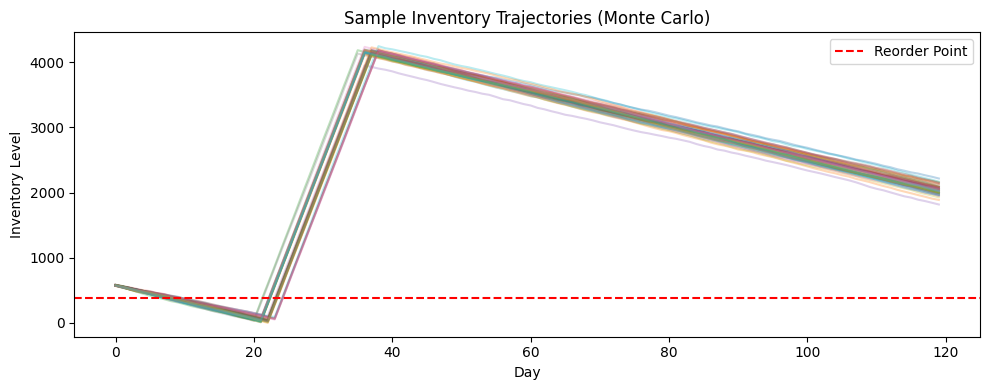

In [21]:
plt.figure(figsize=(10,4))

for i in range(50):
    plt.plot(all_inventory_paths[i], alpha=0.3)

plt.axhline(REORDER_POINT, linestyle="--", color="red", label="Reorder Point")
plt.xlabel("Day")
plt.ylabel("Inventory Level")
plt.title("Sample Inventory Trajectories (Monte Carlo)")
plt.legend()
plt.tight_layout()
plt.show()


# now find automatic good cases:

In [24]:
model = XGBRegressor()
model.load_model("xgboost_demand_model.json")

residuals = pd.read_csv("demand_residuals_xgboost_morefeatures.csv")["Residual"].values

last_features = pd.read_csv("last_known_features_xgboost_morefeatures.csv")
feature_cols = pd.read_csv("feature_columns_xgboost_morefeatures.csv")["feature_name"].tolist()
last_features = last_features[feature_cols]

In [25]:

HORIZON_DAYS = 60
N_SIMULATIONS = 500
LEAD_TIME_DAYS = 14
INITIAL_INVENTORY = 600

In [26]:
def run_single_simulation(reorder_point, order_quantity):
    inventory = INITIAL_INVENTORY
    pending_orders = []
    inventory_history = []
    stockout = False

    features = last_features.copy()

    for _ in range(HORIZON_DAYS):

        # Predict mean demand
        mean_demand = model.predict(features)[0]

        # Add stochasticity
        demand = max(0, mean_demand + np.random.choice(residuals))

        # Receive incoming orders
        pending_orders = [(d-1, q) for d, q in pending_orders]
        arrivals = [q for d, q in pending_orders if d <= 0]
        inventory += sum(arrivals)
        pending_orders = [(d, q) for d, q in pending_orders if d > 0]

        # Apply demand
        if demand > inventory:
            stockout = True
            inventory = 0
        else:
            inventory -= demand

        inventory_history.append(inventory)

        # Reorder logic
        if inventory <= reorder_point:
            pending_orders.append((LEAD_TIME_DAYS, order_quantity))

        # Roll lag features forward
        features["lag_30"] = features["lag_14"]
        features["lag_14"] = features["lag_7"]
        features["lag_7"]  = features["lag_1"]
        features["lag_1"]  = demand

        features["roll_mean_7"] = (features["roll_mean_7"] * 6 + demand) / 7

    return stockout, inventory_history

In [27]:
def evaluate_policy(reorder_point, order_quantity):
    stockouts = 0
    all_inventory = []

    for _ in range(N_SIMULATIONS):
        so, inv_hist = run_single_simulation(reorder_point, order_quantity)
        stockouts += int(so)
        all_inventory.extend(inv_hist)

    stockout_prob = stockouts / N_SIMULATIONS
    avg_inventory = np.mean(all_inventory)

    return stockout_prob, avg_inventory

In [28]:
REORDER_POINTS = [225, 275, 300, 350, 379, 400, 450]
ORDER_QUANTITIES = [200, 250, 300, 350, 400]

results = []

for rop in REORDER_POINTS:
    for oq in ORDER_QUANTITIES:
        print(f"Evaluating policy: ROP={rop}, Q={oq}")

        stockout_prob, avg_inventory = evaluate_policy(rop, oq)

        results.append({
            "Reorder_Point": rop,
            "Order_Quantity": oq,
            "Stockout_Probability": stockout_prob,
            "Average_Inventory": avg_inventory
        })

Evaluating policy: ROP=225, Q=200
Evaluating policy: ROP=225, Q=250
Evaluating policy: ROP=225, Q=300
Evaluating policy: ROP=225, Q=350
Evaluating policy: ROP=225, Q=400
Evaluating policy: ROP=275, Q=200
Evaluating policy: ROP=275, Q=250
Evaluating policy: ROP=275, Q=300
Evaluating policy: ROP=275, Q=350
Evaluating policy: ROP=275, Q=400
Evaluating policy: ROP=300, Q=200
Evaluating policy: ROP=300, Q=250
Evaluating policy: ROP=300, Q=300
Evaluating policy: ROP=300, Q=350
Evaluating policy: ROP=300, Q=400
Evaluating policy: ROP=350, Q=200
Evaluating policy: ROP=350, Q=250
Evaluating policy: ROP=350, Q=300
Evaluating policy: ROP=350, Q=350
Evaluating policy: ROP=350, Q=400
Evaluating policy: ROP=379, Q=200
Evaluating policy: ROP=379, Q=250
Evaluating policy: ROP=379, Q=300
Evaluating policy: ROP=379, Q=350
Evaluating policy: ROP=379, Q=400
Evaluating policy: ROP=400, Q=200
Evaluating policy: ROP=400, Q=250
Evaluating policy: ROP=400, Q=300
Evaluating policy: ROP=400, Q=350
Evaluating pol

In [29]:
results_df = pd.DataFrame(results)
results_df.to_csv("policy_optimization_results.csv", index=False)

print("\nPolicy Optimization Results")
print(results_df.sort_values("Average_Inventory"))


Policy Optimization Results
    Reorder_Point  Order_Quantity  Stockout_Probability  Average_Inventory
0             225             200                 1.000        1110.868405
5             275             200                 0.996        1183.991793
10            300             200                 0.972        1220.317562
15            350             200                 0.330        1316.780243
1             225             250                 1.000        1379.485464
20            379             200                 0.024        1381.873392
25            400             200                 0.000        1422.355233
6             275             250                 0.994        1511.566660
30            450             200                 0.000        1525.014257
11            300             250                 0.966        1558.734973
2             225             300                 1.000        1631.547698
16            350             250                 0.376        1665.198

In [30]:
SERVICE_LEVEL_TARGET = 0.05   # 5% stockout allowed

feasible = results_df[
    results_df["Stockout_Probability"] <= SERVICE_LEVEL_TARGET
]

optimal_policy = feasible.sort_values("Average_Inventory").iloc[0]

print("\nRecommended Policy")
print("------------------")
print(optimal_policy)


Recommended Policy
------------------
Reorder_Point            379.000000
Order_Quantity           200.000000
Stockout_Probability       0.024000
Average_Inventory       1381.873392
Name: 20, dtype: float64


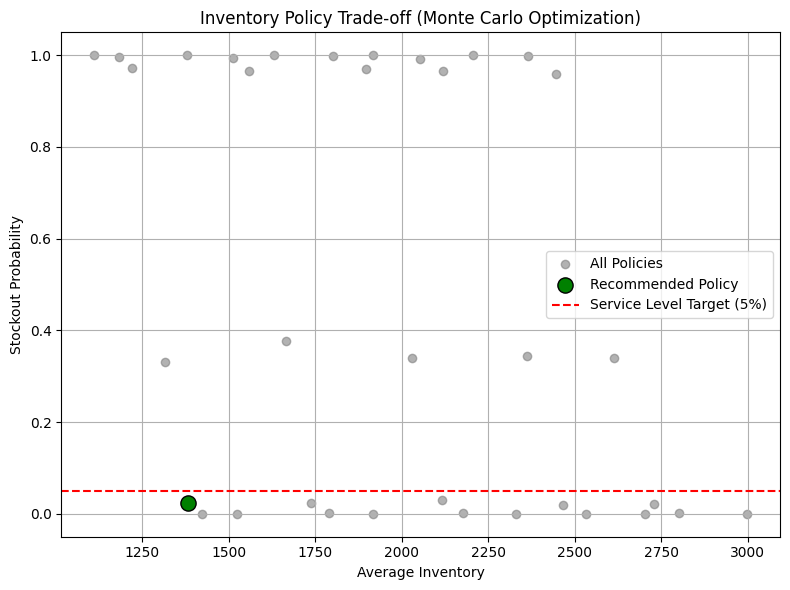

In [31]:
plt.figure(figsize=(8,6))

# All policies
plt.scatter(
    results_df["Average_Inventory"],
    results_df["Stockout_Probability"],
    color="gray",
    alpha=0.6,
    label="All Policies"
)

# Optimal policy
plt.scatter(
    optimal_policy["Average_Inventory"],
    optimal_policy["Stockout_Probability"],
    color="green",
    s=120,
    label="Recommended Policy",
    edgecolor="black"
)

# Service level target
plt.axhline(
    y=0.05,
    color="red",
    linestyle="--",
    label="Service Level Target (5%)"
)

plt.xlabel("Average Inventory")
plt.ylabel("Stockout Probability")
plt.title("Inventory Policy Trade-off (Monte Carlo Optimization)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


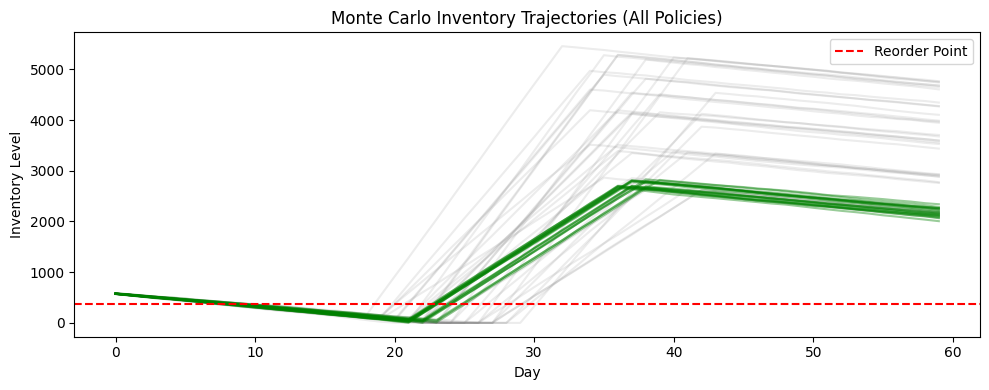

In [32]:
plt.figure(figsize=(10,4))

# Plot some paths for all policies (light gray)
for _, row in results_df.iterrows():
    if (
        row["Reorder_Point"] == optimal_policy["Reorder_Point"]
        and row["Order_Quantity"] == optimal_policy["Order_Quantity"]
    ):
        continue  # skip optimal for now

    _, inv_paths = run_single_simulation(
        int(row["Reorder_Point"]),
        int(row["Order_Quantity"])
    )

    plt.plot(inv_paths, color="gray", alpha=0.15)

# Plot optimal policy paths in green
for _ in range(20):
    _, inv_paths = run_single_simulation(
        int(optimal_policy["Reorder_Point"]),
        int(optimal_policy["Order_Quantity"])
    )
    plt.plot(inv_paths, color="green", alpha=0.4)

# Reorder point
plt.axhline(
    optimal_policy["Reorder_Point"],
    color="red",
    linestyle="--",
    label="Reorder Point"
)

plt.xlabel("Day")
plt.ylabel("Inventory Level")
plt.title("Monte Carlo Inventory Trajectories (All Policies)")
plt.legend()
plt.tight_layout()
plt.show()
